# Red Neuronal en Python para conducción de vehiculo

Se crea una red neuronal simple, con 3 capas, neuronas con valores de entrada -1 a 1 y de salida 0 a 1 indicando encender o no los motores de un coche controlado por un ESP8266 y Arduino.

In [1]:
import numpy as np

# Creamos la clase


class NeuralNetwork:

    def __init__(self, layers, activation='tanh'):
        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_prime = sigmoid_derivada
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_prime = tanh_derivada

        # inicializo los pesos
        self.weights = []
        self.deltas = []
        # capas = [2,3,4]
        # random de pesos varia entre (-1,1)
        # asignación de valores aleatorios a capa de entrada y capa oculta
        for i in range(1, len(layers) - 1):
            r = 2*np.random.random((layers[i-1] + 1, layers[i] + 1)) - 1
            self.weights.append(r)
        # asigno aleatorios a capa de salida
        r = 2*np.random.random((layers[i] + 1, layers[i+1])) - 1
        self.weights.append(r)

    def fit(self, X, y, learning_rate=0.2, epochs=100000):
        # Agrego columna de unos a las entradas X
        # Con esto agregamos la unidad de Bias a la capa de entrada
        ones = np.atleast_2d(np.ones(X.shape[0]))
        X = np.concatenate((ones.T, X), axis=1)

        for k in range(epochs):
            i = np.random.randint(X.shape[0])
            a = [X[i]]

            for l in range(len(self.weights)):
                dot_value = np.dot(a[l], self.weights[l])
                activation = self.activation(dot_value)
                a.append(activation)
            # Calculo la diferencia en la capa de salida y el valor obtenido
            error = y[i] - a[-1]
            deltas = [error * self.activation_prime(a[-1])]

            # Empezamos en el segundo layer hasta el ultimo
            # (Una capa anterior a la de salida)
            for l in range(len(a) - 2, 0, -1):
                deltas.append(deltas[-1].dot(self.weights[l].T)
                              * self.activation_prime(a[l]))
            self.deltas.append(deltas)

            # invertir
            # [level3(output)->level2(hidden)]  => [level2(hidden)->level3(output)]
            deltas.reverse()

            # backpropagation
            # 1. Multiplcar los delta de salida con las activaciones de entrada
            #    para obtener el gradiente del peso.
            # 2. actualizo el peso restandole un porcentaje del gradiente
            for i in range(len(self.weights)):
                layer = np.atleast_2d(a[i])
                delta = np.atleast_2d(deltas[i])
                self.weights[i] += learning_rate * layer.T.dot(delta)

            if k % 10000 == 0:
                print('epochs:', k)

    def predict(self, x):
        ones = np.atleast_2d(np.ones(x.shape[0]))
        a = np.concatenate((np.ones(1).T, np.array(x)), axis=0)
        for l in range(0, len(self.weights)):
            a = self.activation(np.dot(a, self.weights[l]))
        return a

    def print_weights(self):
        print("LISTADO PESOS DE CONEXIONES")
        for i in range(len(self.weights)):
            print(self.weights[i])

    def get_weights(self):
        return self.weights

    def get_deltas(self):
        return self.deltas

# Al crear la red, podremos elegir entre usar la funcion sigmoid o tanh


def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))


def sigmoid_derivada(x):
    return sigmoid(x)*(1.0-sigmoid(x))


def tanh(x):
    return np.tanh(x)


def tanh_derivada(x):
    return 1.0 - x**2


## Comportamiento del Coche Robot

Se instancia la red neuronal que nos dará los pesos para las conexiones que utilizaremos en el vehículo.

In [2]:
# Red Coche para Evitar obstáculos
nn = NeuralNetwork([2, 3, 2], activation='tanh')
X = np.array([[-1, -1],  # sin obstaculos
              [-1, 0],   # sin obstaculos
              [-1, 1],   # sin obstaculos
              [0, -1],   # obstaculo derecha
              [0,  0],   # obstaculo centro
              [0,  1],   # obstaculo izquierda
              [1, -1],   # demasiado cerca izquierda
              [1,  0],   # demasiado cerca centro
              [1,  1]    # demasiado cerca derecha
              ])
# las salidas 'y' se corresponden con encender (o no) los motores
y = np.array([[1, 1],  # avanzar
              [1, 1],  # avanzar
              [1, 1],  # avanzar
              [1, 0],  # giro derecha
              [1, 0],  # giro derecha
              [0, 1],  # giro izquierda
              [0, 0],  # retroceder
              [0, 0],  # retroceder
              [0, 0]  # retroceder
              ])
nn.fit(X, y, learning_rate=0.03, epochs=40001)


def valNN(x):
    return (int)(abs(round(x)))


index = 0
for e in X:
    prediccion = nn.predict(e)
    print("X:", e, "esperado:", y[index], "obtenido:", valNN(
        prediccion[0]), valNN(prediccion[1]))
    index = index+1


epochs: 0
epochs: 10000
epochs: 20000
epochs: 30000
epochs: 40000
X: [-1 -1] esperado: [1 1] obtenido: 1 1
X: [-1  0] esperado: [1 1] obtenido: 1 1
X: [-1  1] esperado: [1 1] obtenido: 1 1
X: [ 0 -1] esperado: [1 0] obtenido: 1 0
X: [0 0] esperado: [1 0] obtenido: 1 0
X: [0 1] esperado: [0 1] obtenido: 0 1
X: [ 1 -1] esperado: [0 0] obtenido: 0 0
X: [1 0] esperado: [0 0] obtenido: 0 0
X: [1 1] esperado: [0 0] obtenido: 0 0


# Graficamos la función coste 

Vemos como el gradiente desciende y disminuye el error a medida que pasan las iteraciones de aprendizaje

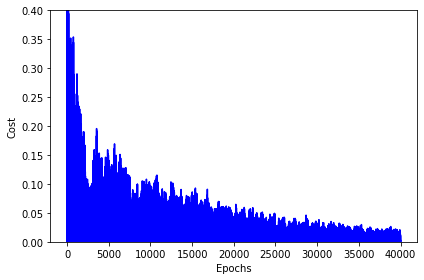

In [3]:
import matplotlib.pyplot as plt

deltas = nn.get_deltas()
valores = []
index = 0
for arreglo in deltas:
    valores.append(arreglo[1][0] + arreglo[1][1])
    index = index+1

plt.plot(range(len(valores)), valores, color='b')
plt.ylim([0, 0.4])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()


# Generamos el código para Arduino

Se transforman las salidas para poder ser pegadas en el código para Arduino

In [4]:
def to_str(name, W):
    s = str(W.tolist()).replace('[', '{').replace(']', '}')
    return 'const float '+name+'['+str(W.shape[0])+']['+str(W.shape[1])+'] = ' + s + ';'


In [5]:
# Obtenermos los pesos entrenados para poder usarlos en el codigo de arduino
pesos = nn.get_weights()

print('// Reemplazar estas lineas en tu codigo arduino:')
print('// const float HIDDEN_WEIGHTS...')
print('// const float OUTPUT_WEIGHTS...')
print('// Con lo pesos entrenados.')
print('\n')
print(to_str('HIDDEN_WEIGHTS', pesos[0]))
print(to_str('OUTPUT_WEIGHTS', pesos[1]))


// Reemplazar estas lineas en tu codigo arduino:
// const float HIDDEN_WEIGHTS...
// const float OUTPUT_WEIGHTS...
// Con lo pesos entrenados.


const float HIDDEN_WEIGHTS[3][4] = {{0.7993371118882053, -1.4047014502226984, 0.9414582048050834, 0.07642009631120551}, {-0.13297965743408063, -3.341301702562721, 0.6131066138656246, -2.3255056135814103}, {0.23604578914209137, 1.6221600044678037, -0.2315280391669793, -0.7173392995794886}};
const float OUTPUT_WEIGHTS[4][2] = {{0.889885617059632, 0.44366950248439924}, {-0.5935876267502912, 2.0265443012303415}, {1.1108713149135987, 2.0667292793021828}, {2.1970641405729454, 0.10949879437586214}};


## Referencias

Juan Ignacio Bagnato www.aprendemachinelearning.com